In [6]:
from Classes.Analysis import Analysis
import numpy as np
from matplotlib import pyplot as plt
from Classes.Visualizer import Visualizer

class System(Analysis):
    def __init__(self, graph_location):
        super().__init__(graph_location)

    def odesystem(self, t, Y, *params):
        #TODO: look at biology side, try to replicate graphs
        #TODO: explore the model(s)
        # start simple, bacteria-resource, see how the bacteria and reosurces grow/shrink, bacteria should hit carrying capacity, nutrient should reach 0, not negative, etc
        graph_object, phage_nodes, bacteria_nodes, nutrient_nodes, M, e_vector, tau_vector, v_matrix, K_matrix, r_matrix, B_matrix = params
        graph = graph_object.graph
        def g(N, v, K):
            return (N * v) / (N + K)

        Y = self.check_cutoff(Y)
        
        N, U, I, P = self.unflatten_initial_matrix(Y, [len(nutrient_nodes), len(bacteria_nodes), (len(bacteria_nodes), M), len(phage_nodes)])
        new_N = np.zeros_like(N)
        new_U = np.zeros_like(U)
        new_I = np.zeros_like(I)
        new_P = np.zeros_like(P)
        #update N vector
        for nutrient in nutrient_nodes:
            n_index = nutrient_nodes.index(nutrient)
            e_value = e_vector[n_index] 
            sum_g = 0
            sum_u = 0
            sum_i = 0
            for bacteria in bacteria_nodes:
                b_index = bacteria_nodes.index(bacteria)
                if graph.has_edge(bacteria, nutrient):
                    v = v_matrix[b_index, n_index]
                    K = K_matrix[b_index, n_index]
                    sum_g += g(N[n_index], v, K)
                    sum_u += U[b_index]
                    sum_i += np.sum(I[b_index])
            new_N[n_index] = -(e_value * sum_g) * (sum_u + sum_i)
        
        # update U vector, i, and j are flipped relative to what is seen in update N vector for v, K, and r matrices because of how the row and columns are defined in the graph
        # dont sum U in left and right, because we are looking at an individual bacteria
        for uninfected in bacteria_nodes:
            u_index = bacteria_nodes.index(uninfected)
            g_sum = 0
            right = 0
            for nutrient in nutrient_nodes:
                n_index = nutrient_nodes.index(nutrient)
                if graph.has_edge(uninfected, nutrient):
                    g_sum += g(N[n_index], v_matrix[u_index, n_index], K_matrix[u_index, n_index])
            for phage in phage_nodes:
                p_index = phage_nodes.index(phage)
                if graph.has_edge(phage, uninfected):
                    right += r_matrix[p_index, u_index] * P[p_index]
            new_U[u_index] = g_sum * U[u_index] - right * U[u_index]

        for infected in bacteria_nodes:
            i_index = bacteria_nodes.index(infected)
            for infected_stage in range(0, M):
                if infected_stage == 0:
                    left_sum = 0
                    right_sum = 0
                    for phage in phage_nodes:
                        p_index = phage_nodes.index(phage)
                        if graph.has_edge(phage, infected):
                            left_sum += r_matrix[p_index, i_index] * P[p_index]
                            right_sum += M / tau_vector[i_index] * I[i_index, 0]
                    new_I[i_index, 0] = left_sum * U[i_index] - right_sum
                else:
                    m_tau = M / tau_vector[i_index]
                    right = I[i_index, infected_stage - 1] - I[i_index, infected_stage]
                    new_I[i_index, infected_stage] = m_tau * right
        
        for phage in phage_nodes:
            p_index = phage_nodes.index(phage)
            left_sum = 0
            right_sum = 0
            for infected in bacteria_nodes:
                i_index = bacteria_nodes.index(infected)
                if graph.has_edge(phage, infected):
                    left_sum += B_matrix[p_index, i_index] * M / tau_vector[i_index] * I[i_index, -1]
                    right_sum += r_matrix[p_index, i_index] * (U[i_index] + np.sum(I[i_index])) * P[p_index]
            new_P[p_index] = left_sum - right_sum

        flattened_y1 = self.flatten_lists_and_matrices(new_N, new_U, new_I, new_P)
        return flattened_y1

In [ ]:
graph = System('simple_test_2.gexf')
phage_nodes = graph.get_nodes_of_type('P')
bacteria_nodes = graph.get_nodes_of_type('B')
resource_nodes = graph.get_nodes_of_type('R')
environemnt_nodes = graph.get_nodes_of_type('E')

R0 = graph.initialize_new_parameter_from_node(resource_nodes, "Initial_Concentration")
U0 = graph.initialize_new_parameter_from_node(bacteria_nodes, "Initial_Population")
I0 = graph.initialize_new_matrix(len(U0), graph.M)
P0 = graph.initialize_new_parameter_from_node(phage_nodes, "Initial_Population")

e_vector = graph.initialize_new_parameter_from_node(resource_nodes, 'e')
tau_vector = graph.initialize_new_parameter_from_node(bacteria_nodes, 'tau')
v_matrix = graph.initialize_new_parameter_from_edges(bacteria_nodes, resource_nodes, 'v')
K_matrix = graph.initialize_new_parameter_from_edges(bacteria_nodes, resource_nodes, 'K')
r_matrix = graph.initialize_new_parameter_from_edges(phage_nodes, bacteria_nodes, 'r')
B_matrix = graph.initialize_new_parameter_from_edges(phage_nodes, bacteria_nodes, 'Burst_Size')
visualizer = Visualizer(graph)

In [8]:
new_graphing_data = [R0, U0, I0, P0]
flattened = graph.flatten_lists_and_matrices(*new_graphing_data)
new_non_graphing_data_vectors = [e_vector, tau_vector]
new_non_graphing_data_matrices = [v_matrix, K_matrix, r_matrix, B_matrix]

solved_system = graph.solve_system(graph.odesystem, flattened, graph, *[phage_nodes, bacteria_nodes, resource_nodes, int(graph.M)], *new_non_graphing_data_vectors, *new_non_graphing_data_matrices)
solved_y = solved_system.y
overall_y = graph.unflatten_initial_matrix(solved_system.y, [len(resource_nodes), len(bacteria_nodes), int(graph.M), len(phage_nodes)])
overall_y[2] = visualizer.sum_up_columns(overall_y[2], int(graph.M))

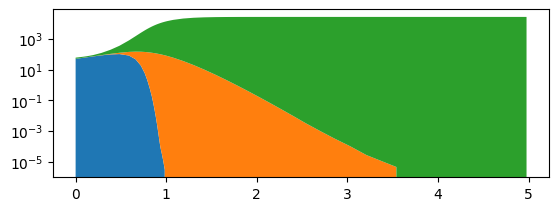

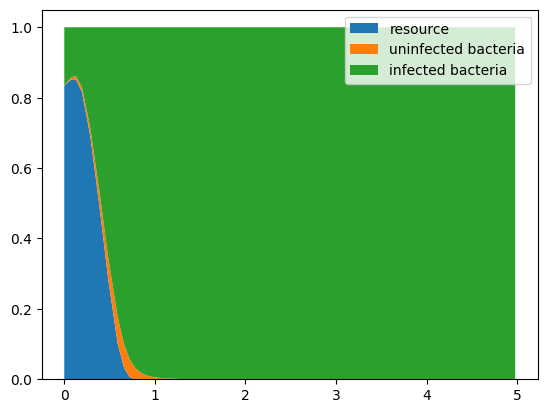

In [18]:
new_graphing_data = [R0, U0, I0, P0]
flattened = graph.flatten_lists_and_matrices(*new_graphing_data)
new_non_graphing_data_vectors = [e_vector, tau_vector]
new_non_graphing_data_matrices = [v_matrix, K_matrix, r_matrix, B_matrix]

solved_system = graph.solve_system(graph.odesystem, flattened, graph, *[phage_nodes, bacteria_nodes, resource_nodes, int(graph.M)], *new_non_graphing_data_vectors, *new_non_graphing_data_matrices)
solved_y = solved_system.y
overall_y = graph.unflatten_initial_matrix(solved_system.y, [len(resource_nodes), len(bacteria_nodes), int(graph.M), len(phage_nodes)])
overall_y[2] = visualizer.sum_up_columns(overall_y[2], int(graph.M))
new_overall_y = [overall_y[i][0] for i in range(len(overall_y))]
number_time_steps_to_show = 50
solved_t = solved_system.t
solved_t_new = solved_t[:number_time_steps_to_show]
for i in range(len(new_overall_y)):
    new_overall_y[i] = new_overall_y[i][:number_time_steps_to_show]
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

new_overall_y = new_overall_y[1:4]
line = ax.stackplot(solved_t_new, new_overall_y, labels=["resource", "uninfected bacteria", "infected bacteria", "phage"])

ax.set_yscale('log')
# plt.stackplot(solved_t_new, new_overall_y, labels=["resource", "uninfected bacteria", "infected bacteria", "phage"])
# plt.set_yscale('log')
# plt.legend()
plt.show()

new_overall_y = np.array(new_overall_y)
column_sums = new_overall_y.sum(axis=0)
new_overall_y = new_overall_y / column_sums
plt.stackplot(solved_t_new, new_overall_y, labels=["resource", "uninfected bacteria", "infected bacteria", "phage"])
plt.legend(loc='upper right')
# plots from https://enviromicro-journals.onlinelibrary.wiley.com/doi/full/10.1111/1462-2920.13743
# TODO: remove resources form grpahs below